In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
# mask_upper = torch.triu(torch.ones_like(outputs))
# #mask_lower = torch.tril(torch.ones_like(outputs), diagonal=1)
# masking = (1 - mask_upper)# * (1 - mask_lower)
# outputs = outputs * masking

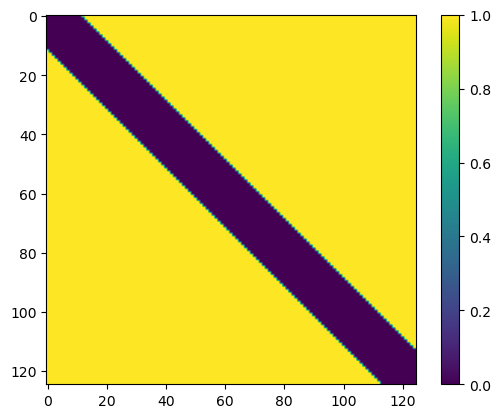

In [2]:
N = 125
outputs = np.zeros((N, N))
outputs = torch.Tensor(outputs)
row_up, col_up = torch.triu_indices(N, N, offset=12)
row_low, col_low = torch.tril_indices(N, N, offset=-12)
outputs[row_up, col_up] = 1
outputs[row_low, col_low] = 1

fig, ax = plt.subplots()
im = ax.imshow(outputs)
fig.colorbar(im)
plt.show()

In [1]:
# standard lib
import os
from pathlib import Path
from typing import Optional, Dict

# scientific libs
import numpy as np
import pandas as pd

# DL libs
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import esm
from esm.data import ESMStructuralSplitDataset
from sklearn.metrics import roc_auc_score

# graph libs
import matplotlib.pyplot as plt

#from esm_utils import *
from tqdm import tqdm

In [2]:
train_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='train', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

valid_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='valid', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

In [3]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

# Freeze all parameters of the pretrained model
for param in model.parameters():
    param.requires_grad = False

In [4]:
# Prepare data, optimizer, and objective/loss function
batch_converter = alphabet.get_batch_converter()
contact_threshold = 15

In [6]:
# rand_example = np.random.randint(len(valid_dataset))
# rand_target = valid_dataset[rand_example]

# print(f"Data point {rand_example}, {rand_target['seq']}")

Data point 229, KDLTIGMSIDDLRLERWQKDRDIFVKKAESLGAKVLVQSANGDDSAQISQIENMLNKNVDVLVIIPHNGDVLSNVISEAKKEGVKVLAYDRLINNADLDFYVSFDNEKVGELQADAIIKEKPEGNYFLMGGSPVDNNAKLFRKGQMKVLQPLIDSGKIKVVGDQWVDSWLAEKALQIMENALTANKNNIDAVVASNDATAGGAIQALSAQGLSGKVAISGQDADLAAIKRIVEGTQTMTVYKPITNLADKAAELSVALGKEEKLEPNAKLNNGLKEVDAYLLDPIVVTKDNIDSTVIKDGFHSKEAVYK


In [5]:
# Fixed example to compare
rand_example = 229
rand_target = valid_dataset[rand_example]

In [6]:
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

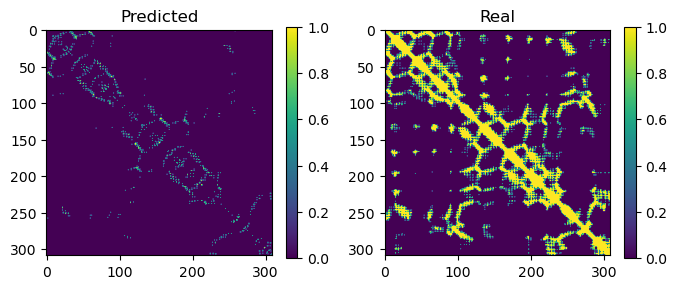

In [7]:
N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c) #['dist'] < contact_threshold)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [8]:
# Modify only the last layer for regression task
model.contact_head.regression = nn.Linear(in_features=model.contact_head.regression.in_features, out_features=1)

# Set requires_grad=True only for the regression layer parameters to be trained
for param in model.contact_head.regression.parameters():
    param.requires_grad = True

In [9]:
for param in model.contact_head.regression.parameters():
    param.requires_grad = True
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

contact_head.regression.weight
contact_head.regression.bias


In [10]:
# remove all the nans
masked_train = []
masked_valid = []

# modify dataset to remove/mask entries without any coordinates/distances
for t in train_dataset:
    mask = ~np.isnan(t["coords"].sum(axis=1))
    mdist = t["dist"][mask][:, mask]
    masked_entry = {
        "seq": "".join(c for c, cm in zip(t['seq'], mask) if cm),
        "ssp": "".join(c for c, cm in zip(t['ssp'], mask) if cm),
        "coords": t["coords"][mask],
        # Boolean values to only recognise distances up to a threshold of 15A
        "dist": mdist < contact_threshold
    }
    masked_train.append(masked_entry)
    
for t in valid_dataset:
    mask = ~np.isnan(t["coords"].sum(axis=1))
    mdist = t["dist"][mask][:, mask]
    masked_entry = {
        "seq": ''.join(c for c, cm in zip(t["seq"], mask) if cm),
        "ssp": ''.join(c for c, cm in zip(t["ssp"], mask) if cm),
        "coords": t["coords"][mask],
        "dist": mdist < contact_threshold
    }
    masked_valid.append(masked_entry)

In [ ]:
# masked_train[229]['dist']

In [ ]:
# N = len(masked_train[229]['dist'])
# fig, ax = plt.subplots(figsize=(8, 3))
# im = ax.imshow(masked_train[299]['dist'])
# fig.colorbar(im)
# ax.set_title("Test")

In [11]:
device = torch.device("cpu")
# if torch.backends.cuda.is_built():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#     device = torch.device("mps")
print(f"Using device {device}")

Using device cpu


In [12]:
# Training loop
learning_rate = 0.003

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
               
# loss is calculated for each input and target pair, mean values calculated manually
loss_fn = nn.BCELoss(reduction="none")
#loss_fn = nn.SmoothL1Loss(reduction='none')

num_epochs = 6

print(f"Epoch\tTrain loss\tTest loss")
for epoch in range(num_epochs):
    model.train()
               
    # Initialise loss for each epoch   
    total_loss = 0
    # Number of sequences used to train model (2048/12312 samples)
    tsize = 1024
    # Training on randomly selected sequences in batches of 10
    for b in tqdm(
        DataLoader(np.random.choice(len(masked_train), size=tsize, replace=False), batch_size=8, shuffle=True),
    ncols=40):
        # Tokenise input sequences
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_train[i]["seq"]) for i in b])
        # Clear gradients for each epoch
        optimizer.zero_grad()
        # Output predictions for batch 
        outputs = model(batch_tokens.to(device), return_contacts=True)
        
        # Apply triangle tensor masking to targets
        # mask_upper = torch.triu(torch.ones_like(outputs["contacts"]), diagonal=4)
        # mask_lower = torch.tril(torch.ones_like(outputs["contacts"]), diagonal=-4)
        # masking = (1 - mask_upper) * (1 - mask_lower)
        
        # targets = targets[np.triu_indices(N, 4)] = 1
        # targets = targets[np.tril_indices(N, -4)] = 1
        # target_mask = torch.zeros_like(outputs["contacts"])
        
        # Initialise objects to 0 to match the format of contact output tensor
        targets = torch.zeros_like(outputs["contacts"])
        mask = torch.zeros_like(outputs["contacts"])
        src_mask = torch.zeros_like(outputs["contacts"])

        # Pull masked and boolean (dist threshold) values from training sequences   
        for i_, ti in enumerate(b):
            cm = masked_train[ti]["dist"]
            N = cm.shape[0]
            targets[i_, :N, :N] = torch.tensor(cm)
            mask[i_, :N, :N] = 1
            row_up, col_up = torch.triu_indices(N, N, offset=12)
            row_low, col_low = torch.tril_indices(N, N, offset=-12)
            src_mask[i_, row_up, col_up] = 1
            src_mask[i_, row_low, col_low] = 1
            targets = targets * src_mask
            
        #targets = targets * masking
        #masked_targets = targets * mask
    
        # Calculates bce loss between predictions and true values
        loss = loss_fn(outputs["contacts"], targets)
        # Manually calculate mean per run (reduction = "none")
        loss = (loss * mask).mean()
        # Pool loss values from each batch
        total_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Updates last layer parameters to reduce loss
        optimizer.step()
        del batch_tokens, targets, mask
    
    valid_loss = 0
    vsize = 1
    for b in DataLoader(range(vsize), batch_size=1, shuffle=True):
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_valid[i]["seq"]) for i in b])
        inputs = batch_tokens
        # contacts
        targets = torch.tensor(np.array([masked_valid[i]["dist"] for i in b]), dtype=torch.float32)
        outputs = model(batch_tokens.to(device), return_contacts=True)
        # Calculates loss between predictions and true values
        
        loss = nn.BCELoss()(outputs["contacts"], targets)
        #loss = nn.SmoothL1Loss()(outputs["contacts"], targets)
        
        # Pool loss values from each batch
        valid_loss += loss.item()
        del batch_tokens, targets
    # Print loss per epoch 
    average_loss = total_loss / tsize
    average_loss_test = valid_loss / vsize
    
    # Print AUC per epoch
    #auc_score = roc_auc_score(targets, outputs)
    
    print(f"{epoch+1}/{num_epochs}\t{average_loss:.4f}\t\t{average_loss_test:.4f}")
    #print("AUC Score:", auc_score)

Epoch	Train loss	Test loss


100%|█| 128/128 [1:41:29<00:00, 47.57s/i


1/6	0.0283		0.6629


100%|█| 128/128 [1:27:22<00:00, 40.95s/i


2/6	0.0233		0.6335


100%|█| 128/128 [1:18:58<00:00, 37.02s/i


3/6	0.0208		0.6291


100%|█| 128/128 [1:41:50<00:00, 47.74s/i


4/6	0.0179		0.6504


100%|█| 128/128 [1:40:47<00:00, 47.25s/i


5/6	0.0166		0.6821


100%|█| 128/128 [1:30:10<00:00, 42.27s/i


6/6	0.0159		0.7004


In [ ]:
# 512 BCE
# Epoch	Train loss	Test loss

# 100%|███| 64/64 [43:44<00:00, 41.00s/it]

# 1/5	0.0306		0.6883

# 100%|███| 64/64 [39:50<00:00, 37.35s/it]

# 2/5	0.0265		0.6642

# 100%|███| 64/64 [39:19<00:00, 36.87s/it]

# 3/5	0.0262		0.6499

# 100%|███| 64/64 [37:28<00:00, 35.13s/it]

# 4/5	0.0234		0.6433

# 100%|███| 64/64 [37:51<00:00, 35.49s/it]

# 5/5	0.0226		0.6337

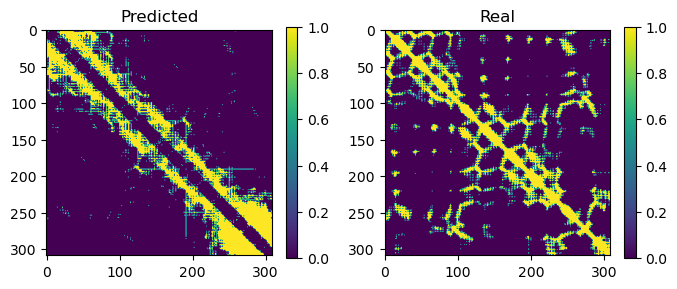

In [15]:
# trained_model_128_SL lr 0.001 ep 5
# batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
# rand_target_c = rand_target['dist'] < contact_threshold

# outputs = model(batch_tokens, return_contacts=True)

# N = len(batch_strs[0])
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target_c)
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show()

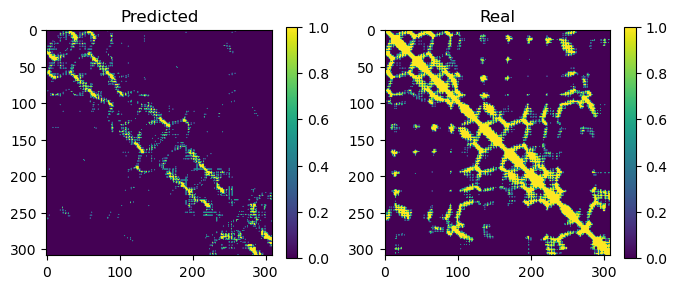

In [15]:
# trained_model_512_BCE lr 0.0025 5 ep
# batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
# rand_target_c = rand_target['dist'] < contact_threshold

# outputs = model(batch_tokens, return_contacts=True)

# N = len(batch_strs[0])
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target_c)
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show()

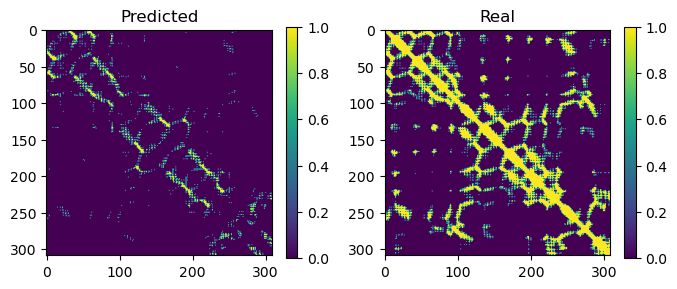

In [15]:
# trained_model_1024_BCE 0.003 lr 6 ep
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [14]:
# Save the fine tuned model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'trained_model_1024_BCE.pth')

Data point 1510, MERTVVETRYGRLRGEMNEGVFVWKGIPYAKAPVGERRFLPPEPPDAWDGVREATSFGPVVMQPSDPIFSGLLGRMSEAPSEDGLYLNIWSPAADGKKRPVLFWIHGGAFLFGSGSSPWYDGTAFAKHGDVVVVTINYRMNVFGFLHLGDSFGEAYAQAGNLGILDQVAALRWVKENIAAFGGDPDNITIFGESAGAASVGVLLSLPEASGLFRRAMLQSGSGSLLLRSPETAMAMTERILDKAGIRPGDRERLLSIPAEELLRAALSLGPGVMYGPVVDGRVLRRHPIEALRYGAASGIPILIGVTKDEYNLFTLTDPSWTKLGEKELLDRINREVGPVPEEAIRYYKETAEPSAPTWQTWLRIMTYRVFVEGMLRTADAQAAQGADVYMYRFDYETPVFGGQLKACHALELPFVFHNLHQPGVANFVGNRPEREAIANEMHYAWLSFARTGDPNGAHLPEAWPAYTNERKAAFVFSAASHVEDDPFGRERAAWQGR


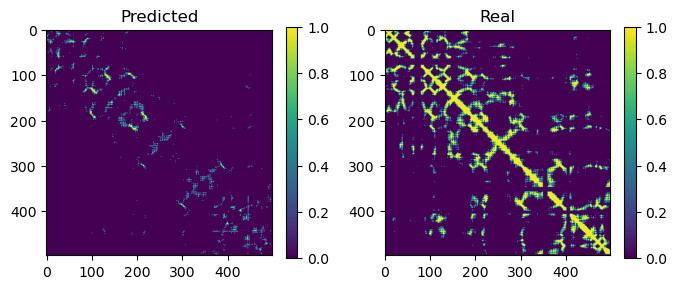

In [26]:
# trained_model_1024_BCE 0.003 lr 6 ep

rand_example = np.random.randint(len(valid_dataset))
rand_target = valid_dataset[rand_example]

print(f"Data point {rand_example}, {rand_target['seq']}")

batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [29]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
}, 'trained_model_1024_BCE_inf.pth')

In [30]:
torch.save(model.state_dict(), 'model_weights_1024_BCE.pth')

In [31]:
torch.save(model, 'trained_model_1024_BCE_6ep.pth')